# "Scraping" Notícias

In [ ]:
#Instalar bibliotecas necessárias 
!pip install pdfplumber
!pip install xlsxwriter

In [ ]:
# Importar as bibliotecas
import pandas as pd
import os
import pdfplumber
import  xlsxwriter

In [ ]:
path = '/content/textos/' # Criar pasta para armazenar os textos
files = os.listdir(path) # Listar os arquivos

In [ ]:
# Leitura dos arquivos pdf
data = []

for f in files:
  try:
    with pdfplumber.open(path+f) as pdf:
      for i in range(len(pdf.pages)):
        page = pdf.pages[i]
        data.append({
          'arquivo': f,
          'corpo': page.extract_text()
        })
  except:
    pass

df = pd.DataFrame(data)
df

,arquivo,corpo
0,d-emtempo-com-br-policia-164208-dupla-e-presa-...,\nASSALTO FRUSTRADO\nDupla é presa após tenta...
1,d-emtempo-com-br-policia-164208-dupla-e-presa-...,"médico, foram encaminhados para o 14 DIP | Fo..."
2,d-emtempo-com-br-policia-164208-dupla-e-presa-...,MAIS LIDAS\nCOMENTÁRIOS\nDeixe seu comentário\...
3,d-emtempo-com-br-policia-164208-dupla-e-presa-...,TERMOS DE USO\nANUNCIE\nFALE COM A REDAÇÃO\n30...
4,d-emtempo-com-br-policia-163056-dupla-suspeita...,\nAGRESSÃO FÍSICA\nDupla suspeita de roubo de...
...,...,...
580,d-emtempo-com-br-policia-amazonas-281650-homem...,", , , q\ndiversas facadas contra as duas mulhe..."
581,d-emtempo-com-br-policia-amazonas-281650-homem...,3\n4 Romero Reis lança vaquinha virtual para a...
582,d-emtempo-com-br-policia-amazonas-281650-homem...,3042-1006 \nportal@emtempo.com.br\nNEWSLETTER...
583,d_emtempo.com-3.pdf,"      \nm R$0,00\n27°\n ..."


In [ ]:
# Remover \n dos textos
df = df.replace('\n',' ', regex=True)
# Exportar para excel
df.to_excel('emtempo.xlsx', encoding='utf8', engine='xlsxwriter')

# Mineração de texto

In [2]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re
import pandas as pd

In [3]:
# Carregar a base, já revisada manualmente
df = pd.read_excel('/content/emtempo.xlsx')

# Remover duplicados
df = df.drop_duplicates(subset=['arquivo'], keep='first')
df.head(3)

,arquivo,titulo,corpo
0,adolescente-agredido-por-populacao-apos-assalt...,Adolescente agredido por população após assalt...,"\nO jovem Marlon Matos Pena, de 18 anos, morre..."
1,adolescente-e-agredido-fisicamente-na-comunida...,Adolescente é agredido fisicamente na comunida...,\nManaus - Um adolescente de 17 anos foi bruta...
2,adolescente-morre-em-hospital-apos-ser-espanca...,Adolescente morre em hospital após ser espanca...,\nUm adolescente de 15 anos foi espancado até ...


In [4]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/manausStopwords.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [6]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [7]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transformar em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(mode = "RGBA", background_color=None,width=800, height=400, max_words=50).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [8]:
df['materiaLimpa'] = df.corpo.apply(parser)
df['tituloLimpo'] = df.titulo.apply(parser)

df['tituloLimpo'] = limparTitulos(df['tituloLimpo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [9]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [11]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(50) 

,Termos,Frequência
21,homem,46
1,agredido,39
26,suspeito,29
104,video,28
10,espancado,27
11,zona,27
3,assalto,20
49,pauladas,16
48,morto,16
2,populacao,15


In [12]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(50)

,Termos,Frequência
137,policia,250
22,zona,217
212,homem,211
20,bairro,177
37,vitima,159
13,suspeito,154
114,local,108
29,agredido,107
266,cicom,105
24,crime,100


## Nuvem de palavras

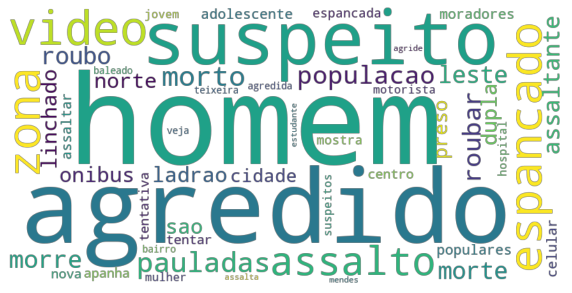

In [ ]:
gerarNuvem(frequenciaTitulo)

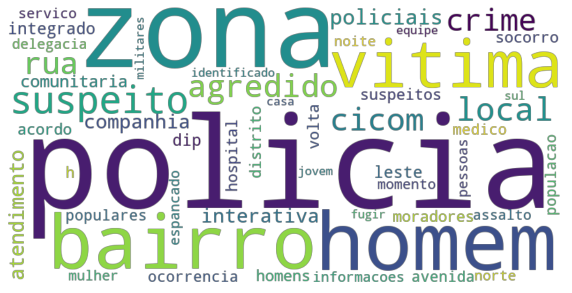

In [ ]:
gerarNuvem(frequenciaMateria)